In [1]:
%%capture
#!pip install wfdb
BASEPATH = '../'
import sys
sys.path.insert(0,'..')

import numpy as np
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
#tf.get_logger().setLevel('ERROR')
from pyecg.utils import reset_seed, plot_spectogram, plot_loss, load_data
from pyecg.utils import integer_mapping, mapping_AAMI
from pyecg.data_info import *
from pyecg.data_handling import DataHandling
from pyecg.report import Reports
from pyecg.models.conv1d_rr_paral import model_arch 

reset_seed()

# Data

In [2]:
#Load Preprocessed data
ds_train = load_data(file_path = '../data/DS1_train.dat')
x_train, y_train, r_train = ds_train.values()
#Load Preprocessed data
ds_val = load_data(file_path = '../data/DS1_val.dat')
x_val, y_val, r_val = ds_val.values()

x_train.shape, len(y_train), r_train.shape,len(y_val)

File loaded: ../data/DS1_train.dat
File loaded: ../data/DS1_val.dat


((46931, 300), 46931, (46931, 4), 3873)

In [3]:
x_train_beatinfo = r_train
x_val_beatinfo = r_val
x_train_beatinfo.shape, x_val_beatinfo.shape

((46931, 4), (3873, 4))

In [4]:
dh = DataHandling()
rp1 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp1

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
train,34585,3939,3758,16,16,3153,105,806,2,100,32,413,0,0,6
val,3348,0,0,0,0,520,0,3,0,0,0,0,0,0,2


In [5]:
from pyecg.data_handling import slice_data
binary_targets=['N','A']
ds_train = slice_data(ds_train, binary_targets)
x_train, y_train, x_train_beatinfo = ds_train.values()
ds_val = slice_data(ds_val, binary_targets)
x_val, y_val, x_val_beatinfo = ds_val.values()
rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp2

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
train,34585,0,0,0,0,0,0,806,0,0,0,0,0,0,0
val,3348,0,0,0,0,0,0,3,0,0,0,0,0,0,0


In [6]:
from pyecg.data_augmentation import aug_decrease,aug_increase
ds_train = aug_decrease(ds_train, label='N', desired_size = 5000)
ds_train = aug_increase(ds_train, desired_size = 5000)
x_train, y_train, x_train_beatinfo  = ds_train.values()

rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp2

(5806, 300) 5806


,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
train,5000,0,0,0,0,0,0,5642,0,0,0,0,0,0,0
val,3348,0,0,0,0,0,0,3,0,0,0,0,0,0,0


In [7]:
#INT_MAP_DICT = {'N':0,'V':1,'S':2,'F':3,'Q':4}
INT_MAP_DICT = {binary_targets[0]:0, binary_targets[1]:1}

y_train = integer_mapping(y_train, INT_MAP_DICT)
y_val = integer_mapping(y_val, INT_MAP_DICT)

# Train

In [8]:
params = {
    'seq_len' : x_train.shape[1],
    'num_classes' : 2,
    'drate' : 0.50,
    'batch_size' : 128,
    'epochs' : 10
}

In [9]:
model_classifier  = model_arch(conv_input_dim=params['seq_len'],beatinfo_input_dim=4, num_classes=params['num_classes'])                                          
#model_classifier  = model_arch(input_dim=params['seq_len'], num_classes=params['num_classes'])                                          


 ----block1:
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 472], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")

 ----block2:
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 536], name='tf.compat.v1.shape_1/Shape:0', description="created by layer 'tf.compat.v1.shape_1'")

 ----block3:
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 568], name='tf.compat.v1.shape_2/Shape:0', description="created by layer 'tf.compat.v1.shape_2'")

 ----block4:
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 584], name='tf.compat.v1.shape_3/Shape:0', description="created by layer 'tf.compat.v1.shape_3'")

 ----block5:
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 592], name='tf.compat.v1.shape_4/Shape:0', description="created by 

In [10]:
#%%capture
#!pip install focal-loss
#from focal_loss import SparseCategoricalFocalLoss

In [11]:
!rm -r /media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1

opt= tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam')
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#for loss try sample_weight
model_classifier.compile(
                      optimizer=opt,
                      #loss=SparseCategoricalFocalLoss(gamma=3),
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy'],
                      loss_weights=None
                      )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5,
                              verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(BASEPATH + "checkpoint/keras.EXP1",
                                                      monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [early_stopping, model_checkpoint, reduce_lr]  

rm: cannot remove '/media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1': No such file or directory


In [12]:
%%time

model_history = model_classifier.fit(
              #x=x_train,
              x={'conv_input':x_train, 'beatinfo_input':x_train_beatinfo},
              y=y_train,
              batch_size=params['batch_size'],
              epochs=params['epochs'],
              verbose=1,
              #callbacks=callbacks,
              validation_data=({'conv_input':x_val, 'beatinfo_input':x_val_beatinfo}, y_val),
              shuffle=True,
              class_weight=None,
              sample_weight=None,
              initial_epoch=0
              )

Epoch 1/10
84/84 [==============================] - 10s 98ms/step - loss: 2.0909 - accuracy: 0.8719 - val_loss: 0.0679 - val_accuracy: 0.9872
Epoch 2/10
84/84 [==============================] - 8s 94ms/step - loss: 0.1843 - accuracy: 0.9475 - val_loss: 0.0235 - val_accuracy: 0.9863
Epoch 3/10
84/84 [==============================] - 8s 100ms/step - loss: 0.0918 - accuracy: 0.9681 - val_loss: 0.0206 - val_accuracy: 0.9869
Epoch 4/10
84/84 [==============================] - 7s 87ms/step - loss: 0.0747 - accuracy: 0.9749 - val_loss: 0.0410 - val_accuracy: 0.9860
Epoch 5/10
84/84 [==============================] - 8s 93ms/step - loss: 0.0591 - accuracy: 0.9802 - val_loss: 0.0353 - val_accuracy: 0.9860
Epoch 6/10
84/84 [==============================] - 8s 93ms/step - loss: 0.0437 - accuracy: 0.9833 - val_loss: 0.0503 - val_accuracy: 0.9857
Epoch 7/10
84/84 [==============================] - 7s 87ms/step - loss: 0.0365 - accuracy: 0.9871 - val_loss: 0.0413 - val_accuracy: 0.9860
Epoch 8/10


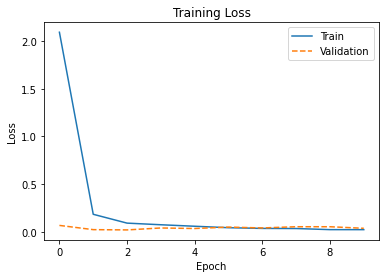

In [13]:
plot_loss(model_history)

In [14]:
import pickle
with open(BASEPATH+'history/EXP1.hist', 'wb') as f:
  pickle.dump(model_history.history, f)


In [15]:
a =model_history.history
min(a['val_loss']), a['val_loss'].index(min(a['val_loss']))

(0.02064661495387554, 2)

# Loading Model

In [16]:
#loaded_model = tf.keras.models.load_model(BASEPATH+'checkpoint/keras.EXP1')
loaded_model = model_classifier
loaded_model.name

'model'

In [17]:
#loaded_model.summary()

In [18]:
#Load Preprocessed Test Set
ds_test = load_data(file_path = '../data/DS2.dat')
x_test, y_test, r_test = ds_test.values()

File loaded: ../data/DS2.dat


In [19]:
from pyecg.data_handling import slice_data
ds_test = slice_data(ds_test, binary_targets)
x_test, y_test, x_test_beatinfo = ds_test.values()
rp2 = dh.report_stats_table([y_test], ['test'])
rp2

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
test,36286,0,0,0,0,0,0,1729,0,0,0,0,0,0,0


In [20]:
y_true = y_test.copy()
#y_true = mapping_AAMI(y_true, MAP_AAMI)

In [21]:
%%time
y_pred_prob = loaded_model.predict([x_test,x_test_beatinfo])

CPU times: user 5.59 s, sys: 49.7 ms, total: 5.64 s
Wall time: 5.42 s


In [22]:
y_pred = integer_mapping(list(y_pred_prob.argmax(axis=-1)), INT_MAP_DICT, inverse=True)

In [23]:
dh = DataHandling()
rp2 = dh.report_stats_table([y_pred, y_true], ['y_pred','y_true'])
rp2

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
y_pred,35778,0,0,0,0,0,0,2237,0,0,0,0,0,0,0
y_true,36286,0,0,0,0,0,0,1729,0,0,0,0,0,0,0


In [24]:
labels = [k for k,v in INT_MAP_DICT.items()]
report = Reports(y_true=y_true, y_pred=y_pred, labels=labels)
normalize = None
#report.plot_confusion_matrix(normalize=normalize, values_format='')
print(report.the_classification_report())
#report.metrics_table()


              precision    recall  f1-score   support

           A     0.4032    0.5217    0.4549      1729
           N     0.9769    0.9632    0.9700     36286

    accuracy                         0.9431     38015
   macro avg     0.6901    0.7424    0.7124     38015
weighted avg     0.9508    0.9431    0.9466     38015

